# OPV simulation tutorial
To run this example, additionally the GAFF forcefield will have to be installed. This can be done as follows:
```
git clone git@github.com:Santiso-Group/GAFF-foyer.git
cd GAFF-foyer
pip install -e .
```
_the way the GAFF repo works is through entrypoints which can be finicky--I think the -e flag is required?_

## Table of contents
- [Acquire a starting structure](#comp)
- [Create a simulation volume](#box)
- [Choose and apply a forcefield](#ff)
- [Run simulation](#run)
- [Analysis](#analyze)

In [77]:
import warnings

import numpy as np
import matplotlib.pyplot as plt

import mbuild as mb
from mbuild.formats.hoomd_simulation import create_hoomd_simulation
import parmed as pmd
import foyer
import hoomd

<a id="comp"></a>
## Starting Structure
Molecular dynamics (MD) is a way of modelling bulk atomic systems using classical (as opposed to quantum) physics. TODO make this good or link to a good explanation of MD 

In order to simulate a bulk morphology of an OPV polymer first we need a structure-- we're going to use [mbuild](https://mosdef.org/mbuild/index.html) to load a structure from a mol2 file. (Mbuild can also be used to programatically create lots of intricate structures, and for that we recommend their [tutorials](https://mosdef.org/mbuild/tutorials/tutorials.html).)

Here we've chosen a 16-mer of poly-3-hexylthiophene (P3HT).

In [73]:
p3ht = mb.load("P3HT_16.mol2")

p3ht.visualize().show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In the above visualization, carbon atoms are colored grey, hydrogens are white, and sulfurs are yellow. Recall, MD is a classical model: it simplifies atoms to particles and bonds to harmonic oscilators (think mass on a spring). So in order to simulate the behavior of atoms in different electronic environments, instead of the computationally expensive task of modelling every electron, we simplify and use different atom "types" to represent elements in similiar electronic environments. Below is an example of the same P3HT 16-mer, but this time it is colored by the atom type assigned to it in the General AMBER Force-Field (GAFF).

In [74]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Load GAFF
    GAFF = foyer.forcefields.load_GAFF()

    # Use foyer to parameterize -- this creates a parmed structure
    p3ht_structure = GAFF.apply(p3ht, assert_dihedral_params=False)

print("Atom types: ", end="")
print(*set([atom.type for atom in p3ht_structure.atoms]), sep=", ")

gaff_colors = {
    'CC_R5': 'brown',
    'SS'   : 'yellow',
    'H4'   : 'white',
    'HA'   : 'tan',
    'C3'   : 'grey',
    'HC'   : 'black',
}
typed_p3ht = mb.clone(p3ht)

for atom_pmd, atom_mb in zip(p3ht_structure, typed_p3ht):
    atom_mb.name = atom_pmd.type
    
typed_p3ht.visualize(color_scheme = gaff_colors).show()

Atom types: h4, c3, cc_r5, ha, ss, hc


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Notice there are three different colors for hydrogen atoms and two different colors for carbon. This visualization is just to show how a forcefield is applied to a molecule, next let's create our simulation volume.

<a id="box"></a>
## Create simulation volume

MD is generally interested in the bulk properties of a material, so a simulation box with periodic boundary conditions is used. You can think of periodic boundary conditions like pacman: when a particle (pacman) exits one side of the space, he reappears on the other. 

![](pacman_pbc.gif)

Our periodic volume is just the same, but in three dimensions. In this way we can simulate an "infinite" volume.

In [13]:
import numpy as np
import mbuild as mb
import parmed as pmd
import foyer
import hoomd
n
import hoomd.md
import hoomd.group

In [76]:
box = mb.Box([10,10,10])
system_box = mb.packing.fill_box(p3ht, 10, box=box)
system_box.visualize().show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [15]:
#system_box_pmd = system_box.to_parmed(box=box) # maybe this step is not necessary.
GAFF = foyer.forcefields.load_GAFF()
struc = GAFF.apply(system_box, assert_dihedral_params=False)

/Users/jenny/miniconda3/envs/antefoyer/lib/python3.7/site-packages/mbuild/compound.py:2443: UserWarning: Guessing that "<C1 pos=( 8.1870, 8.1958, 9.1423), 0 bonds, id: 4916141776>" is element: "C"
  atom, element))
/Users/jenny/miniconda3/envs/antefoyer/lib/python3.7/site-packages/mbuild/compound.py:2443: UserWarning: Guessing that "<S5 pos=( 8.0780, 8.0936, 9.0673), 0 bonds, id: 4916141264>" is element: "S"
  atom, element))
/Users/jenny/miniconda3/envs/antefoyer/lib/python3.7/site-packages/mbuild/compound.py:2443: UserWarning: Guessing that "<H6 pos=( 8.1769, 8.3041, 9.1407), 0 bonds, id: 4916141968>" is element: "H"
  atom, element))
/Users/jenny/miniconda3/envs/antefoyer/lib/python3.7/site-packages/foyer/forcefield.py:248: UserWarning: Parameters have not been assigned to all proper dihedrals. Total system dihedrals: 11320, Parameterized dihedrals: 10680. Note that if your system contains torsions of Ryckaert-Bellemans functional form, all of these torsions are processed as propers

In [4]:
#struc.omm_angle_force()

In [5]:
create_hoomd_simulation(struc, r_cut=1.2, auto_scale=True)

_all = hoomd.group.all()
hoomd.md.integrate.mode_standard(dt=0.0001)
integrator = hoomd.md.integrate.nvt(group=_all, kT=1.0, tau=1)
hoomd.dump.gsd("start.gsd", period=None, group=_all, overwrite=True)
hoomd.dump.gsd("traj.gsd", period=1e4, group=_all, phase=0, overwrite=True)

hoomd.run(1e5)
hoomd.dump.gsd("out.gsd", period=None, group=_all, overwrite=True);

HOOMD-blue 2.9.0 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 02/04/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Lui, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 4020 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 3 exclusions             : 180
notice(2): Particles with 4 exclusions             : 2080
notice(2): Particles with 6 exclusions             : 180
notice(2): Particles with 7 exclusions             :

In [16]:
from utils.cg_utils import gsd_rdf
import matplotlib.pyplot as plt

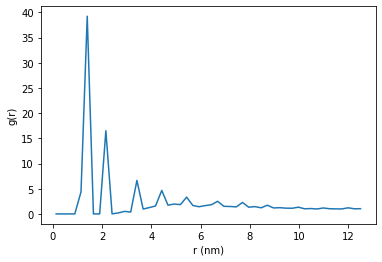

In [17]:
rdf = gsd_rdf("traj.gsd", "ss", "ss", start=-10)
plt.plot(rdf.bin_centers, rdf.rdf)
plt.xlabel("r (nm)")
plt.ylabel("g(r)")
plt.show()